<a href="https://colab.research.google.com/github/yumehara/hackday_2022/blob/main/notebooks/hospital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 病院数・病床数

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q japanize-matplotlib

import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import numpy as np

In [3]:
DIR_NAME = '/content/drive/MyDrive/hackday/'

In [4]:
df_medicalcare = pd.read_csv(os.path.join(DIR_NAME, 'medical_care.csv'))
print(df_medicalcare.shape)

(29614, 11)


In [5]:
df_medicalcare.head()

,tab_code,表章項目,cat01_code,病床の種類_019,cat02_code,R01二次医療圏・市区町村別,time_code,調査年10,unit,value,annotation
0,58,病院数；病床数,1,病院施設数,1000,01 北海道,2019000000,令和元年(2019年),NaN,552,NaN
1,58,病院数；病床数,1,病院施設数,1010,0101 南渡島,2019000000,令和元年(2019年),NaN,33,NaN
2,58,病院数；病床数,1,病院施設数,1020,01202 函館市,2019000000,令和元年(2019年),NaN,27,NaN
3,58,病院数；病床数,1,病院施設数,1030,01236 北斗市,2019000000,令和元年(2019年),NaN,-,NaN
4,58,病院数；病床数,1,病院施設数,1040,01331 松前町,2019000000,令和元年(2019年),NaN,1,NaN


In [6]:
df_medicalcare['表章項目'].unique()

array(['病院数；病床数'], dtype=object)

In [7]:
list(df_medicalcare['病床の種類_019'].unique())

['病院施設数',
 '病院施設数（精神科病院）',
 '病院施設数（一般病院総数）',
 '病院施設数（一般病院総数（療養病床を有する病院(再掲)））',
 '地域医療支援病院(再掲)',
 '救急告示病院(再掲)',
 '病院病床数',
 '病院病床数（精神病床）',
 '病院病床数（感染症病床）',
 '病院病床数（結核病床）',
 '病院病床数（療養病床）',
 '病院病床数（一般病床）']

In [8]:
df_medicalcare['value'] = df_medicalcare['value'].replace('-', np.NaN).astype(float)

In [9]:
df_medicalcare_extract = df_medicalcare[
    (df_medicalcare['病床の種類_019'] == '病院施設数')|(df_medicalcare['病床の種類_019'] == '病院病床数')
][['R01二次医療圏・市区町村別', '病床の種類_019', 'value']]
df_medicalcare_extract.columns = ['市区町村', '種類', 'value']
print(df_medicalcare_extract.shape)

(4556, 3)


In [10]:
df_medicalcare_extract['団体コード'] = df_medicalcare_extract['市区町村'].apply(lambda x: x.split()[0]).astype(int)
df_medicalcare_extract['市区町村名'] = df_medicalcare_extract['市区町村'].apply(lambda x: x.split()[1])
df_medicalcare_extract = df_medicalcare_extract[
    (df_medicalcare_extract['団体コード'] >= 1100)&
    ((df_medicalcare_extract['市区町村名'].str.endswith('市'))|(df_medicalcare_extract['市区町村名'].str.endswith('区'))|
     (df_medicalcare_extract['市区町村名'].str.endswith('町'))|(df_medicalcare_extract['市区町村名'].str.endswith('村')))&
    (df_medicalcare_extract['市区町村名'] != '大阪市')
]
print(df_medicalcare_extract.shape)

(3794, 5)


In [11]:
df_medicalcare_pivot = pd.pivot_table(
    df_medicalcare_extract, 
    index=['市区町村名', '団体コード'], columns='種類', 
    values='value', aggfunc='sum'
).reset_index()

In [12]:
df_hospital = df_medicalcare_pivot[
    (df_medicalcare_pivot['市区町村名'] != '東京都')&(df_medicalcare_pivot['市区町村名'] != '北海道')&
    (~df_medicalcare_pivot['市区町村名'].str.endswith('府'))&(~df_medicalcare_pivot['市区町村名'].str.endswith('県'))
].sort_values('団体コード')

In [13]:
df_add_cirty = pd.DataFrame([
    {'市区町村名': '札幌市', '団体コード': 1100, '行政区': ['中央区', '北区', '東区', '白石区', '豊平区', '南区', '西区', '厚別区', '手稲区', '清田区']},
    {'市区町村名': '仙台市', '団体コード': 4100, '行政区': ['青葉区', '宮城野区', '若林区', '太白区', '泉区']},
    {'市区町村名': 'さいたま市', '団体コード': 11100, '行政区': ['西区', '北区', '大宮区', '見沼区', '中央区', '桜区', '浦和区', '南区', '緑区', '岩槻区']},
    {'市区町村名': '千葉市', '団体コード': 12100, '行政区': ['中央区', '花見川区', '稲毛区', '若葉区', '緑区', '美浜区']},
    {'市区町村名': '横浜市', '団体コード': 14100, '行政区': ['鶴見区', '神奈川区', '西区', '中区', '南区', '保土ケ谷区', '磯子区', '金沢区', '港北区', '戸塚区', '港南区', '旭区', '緑区', '瀬谷区', '栄区', '泉区', '青葉区', '都筑区']},
    {'市区町村名': '川崎市', '団体コード': 14130, '行政区': ['川崎区', '幸区', '中原区', '高津区', '多摩区', '宮前区', '麻生区']},
    {'市区町村名': '相模原市', '団体コード': 14150, '行政区': ['緑区', '中央区', '南区']},
    {'市区町村名': '新潟市', '団体コード': 15100, '行政区': ['北区', '東区', '中央区', '江南区', '秋葉区', '南区', '西区', '西蒲区']},
    {'市区町村名': '静岡市', '団体コード': 22100, '行政区': ['葵区', '駿河区', '清水区']},
    {'市区町村名': '浜松市', '団体コード': 22130, '行政区': ['中区', '東区', '西区', '南区', '北区', '浜北区', '天竜区']},
    {'市区町村名': '名古屋市', '団体コード': 23100, '行政区': ['千種区', '東区', '北区', '西区', '中村区', '中区', '昭和区', '瑞穂区', '熱田区', '中川区', '港区', '南区', '守山区', '緑区', '名東区', '天白区']},
    {'市区町村名': '京都市', '団体コード': 26100, '行政区': ['北区', '上京区', '左京区', '中京区', '東山区', '下京区', '南区', '右京区', '伏見区', '山科区', '西京区']},
    {'市区町村名': '大阪市', '団体コード': 27100, '行政区': ['都島区', '福島区', '此花区', '西区', '港区', '大正区', '天王寺区', '浪速区', '西淀川区', '東淀川区', '東成区', '生野区', '旭区', '城東区', '阿倍野区', '住吉区', '東住吉区', '西成区', '淀川区', '鶴見区', '住之江区', '平野区', '北区', '中央区']},
    {'市区町村名': '堺市', '団体コード': 27140, '行政区': ['堺区', '中区', '東区', '西区', '南区', '北区', '美原区']},
    {'市区町村名': '神戸市', '団体コード': 28100, '行政区': ['東灘区', '灘区', '兵庫区', '長田区', '須磨区', '垂水区', '北区', '中央区', '西区']},
    {'市区町村名': '岡山市', '団体コード': 33100, '行政区': ['北区', '中区', '東区', '南区']},
    {'市区町村名': '広島市', '団体コード': 34100, '行政区': ['中区', '東区', '南区', '西区', '安佐南区', '安佐北区', '安芸区', '佐伯区']},
    {'市区町村名': '北九州市', '団体コード': 40100, '行政区': ['門司区', '若松区', '戸畑区', '小倉北区', '小倉南区', '八幡東区', '八幡西区']},
    {'市区町村名': '福岡市', '団体コード': 40130, '行政区': ['東区', '博多区', '中央区', '南区', '西区', '城南区', '早良区']},
    {'市区町村名': '熊本市', '団体コード': 43100, '行政区': ['中央区', '東区', '西区', '南区', '北区']},
])

In [14]:
df_hospital['親_団体コード'] = df_hospital['団体コード']
for index, row in df_add_cirty.iterrows():
    city_code = row['団体コード']
    name_list = row['行政区']
    high_limit = 20 if row['市区町村名'] != '大阪市' else 30
    df_hospital.loc[
        (df_hospital['団体コード'] > city_code)&
        (df_hospital['団体コード'] < city_code+high_limit)&
        (df_hospital['市区町村名'].isin(name_list)), '親_団体コード'] = city_code

In [15]:
for index, row in df_add_cirty.iterrows():
    name_list = list(df_hospital[df_hospital['親_団体コード'] == row['団体コード']]['市区町村名'])
    print(row['市区町村名'], row['団体コード'], name_list, len(name_list), len(row['行政区']))

札幌市 1100 ['中央区', '北区', '東区', '白石区', '豊平区', '南区', '西区', '厚別区', '手稲区', '清田区'] 10 10
仙台市 4100 ['青葉区', '宮城野区', '若林区', '太白区', '泉区'] 5 5
さいたま市 11100 ['西区', '北区', '大宮区', '見沼区', '中央区', '桜区', '浦和区', '南区', '緑区', '岩槻区'] 10 10
千葉市 12100 ['中央区', '花見川区', '稲毛区', '若葉区', '緑区', '美浜区'] 6 6
横浜市 14100 ['鶴見区', '神奈川区', '西区', '中区', '南区', '保土ケ谷区', '磯子区', '金沢区', '港北区', '戸塚区', '港南区', '旭区', '緑区', '瀬谷区', '栄区', '泉区', '青葉区', '都筑区'] 18 18
川崎市 14130 ['川崎区', '幸区', '中原区', '高津区', '多摩区', '宮前区', '麻生区'] 7 7
相模原市 14150 ['緑区', '中央区', '南区'] 3 3
新潟市 15100 ['北区', '東区', '中央区', '江南区', '秋葉区', '南区', '西区', '西蒲区'] 8 8
静岡市 22100 ['葵区', '駿河区', '清水区'] 3 3
浜松市 22130 ['中区', '東区', '西区', '南区', '北区', '浜北区', '天竜区'] 7 7
名古屋市 23100 ['千種区', '東区', '北区', '西区', '中村区', '中区', '昭和区', '瑞穂区', '熱田区', '中川区', '港区', '南区', '守山区', '緑区', '名東区', '天白区'] 16 16
京都市 26100 ['北区', '上京区', '左京区', '中京区', '東山区', '下京区', '南区', '右京区', '伏見区', '山科区', '西京区'] 11 11
大阪市 27100 ['都島区', '福島区', '此花区', '西区', '港区', '大正区', '天王寺区', '浪速区', '西淀川区', '東淀川区', '東成区', '生野区', '旭区', '城東区', '阿倍野区'

In [16]:
for index, row in df_add_cirty.iterrows():
    city_code = row['団体コード']
    add_row = df_hospital[df_hospital['親_団体コード'] == city_code].sum()
    add_row['市区町村名'] = row['市区町村名']
    add_row['団体コード'] = city_code
    add_row['親_団体コード'] = city_code
    df_hospital = df_hospital.append(add_row, ignore_index=True)

In [17]:
df_hospital = df_hospital.sort_values('団体コード').reset_index(drop=True)
print(df_hospital.shape)
df_hospital.head(10)

(1917, 5)


種類,市区町村名,団体コード,病院施設数,病院病床数,親_団体コード
0,札幌市,1100,202.0,36603.0,1100
1,中央区,1101,39.0,8590.0,1100
2,北区,1102,24.0,3561.0,1100
3,東区,1103,24.0,3641.0,1100
4,白石区,1104,21.0,3683.0,1100
5,豊平区,1105,14.0,2476.0,1100
6,南区,1106,16.0,2846.0,1100
7,西区,1107,23.0,3516.0,1100
8,厚別区,1108,16.0,2614.0,1100
9,手稲区,1109,14.0,3611.0,1100


In [18]:
df_hospital.to_csv(os.path.join(DIR_NAME, 'hospital.csv'), index=False)

In [19]:
df_hospital['病院当たりの病床数'] = df_hospital['病院病床数'] / df_hospital['病院施設数']

In [20]:
df_hospital_tokyo = df_hospital[
    ((df_hospital['団体コード'].astype(str).str[:-3] == '13')&   # 東京都
    ((df_hospital['市区町村名'].str.endswith('区'))))|
    (df_hospital['団体コード'] == 11100) |    # さいたま市
    (df_hospital['団体コード'] == 14100) |    # 横浜市
    (df_hospital['団体コード'] == 23100) |    # 名古屋市
    (df_hospital['団体コード'] == 27100) |    # 大阪市
    (df_hospital['団体コード'] == 40130)      # 福岡市
].copy()

In [21]:
def draw_bar_graph_by_city(df_data, col_name, x_col='市区町村名'):
    data = df_data.sort_values(col_name, ascending=False)[[x_col, col_name]]
    data.plot(x=x_col, kind='bar', title=col_name, figsize=(17, 5))
    mean = data[col_name].mean()
    plt.axhline(y=mean, xmin=0, xmax=1, color='red')
    plt.grid()
    plt.legend().remove()
    plt.show()

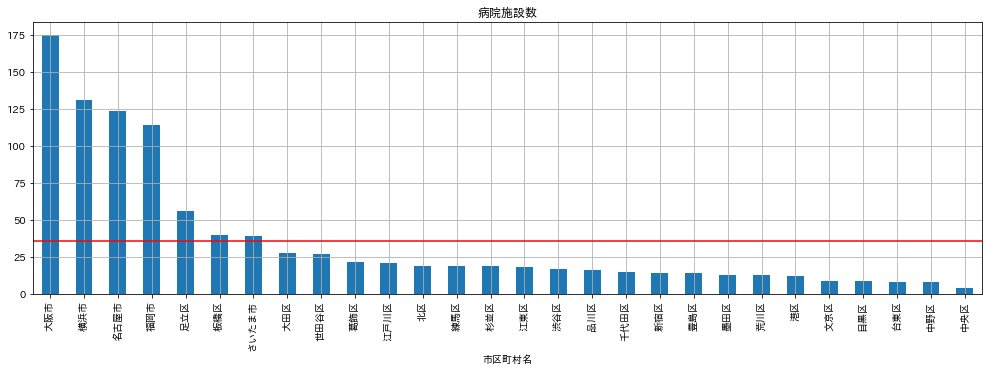

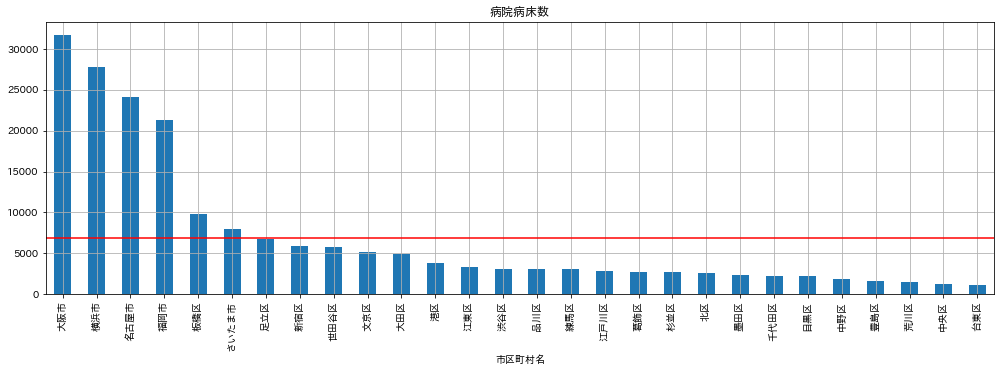

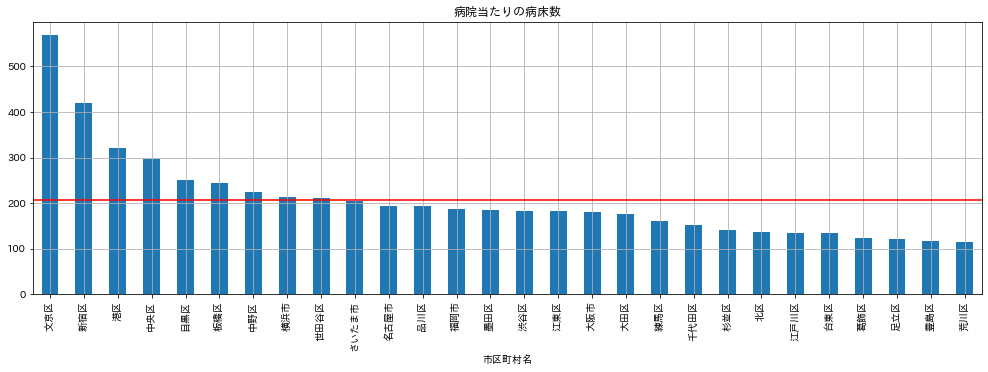

In [22]:
for col in ['病院施設数', '病院病床数', '病院当たりの病床数']:
    draw_bar_graph_by_city(df_hospital_tokyo, col)